# Neural Network for Lidar Odometry

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
# file = "data/train_10k.npy" #has noise in readings
# file = "data/train_100k.npy" #no noise
# file = "data/train_straight_1k.npy" #no noise, no lateral movement relative to initial heading
file = "data/train_dxdy_100k.npy" #no noise, displacement in x and y relative to starting orientation

dataset = np.load(file)

In [3]:
#combine 100k and 200k datasets
# ds2 = np.load("data/train_dxdy_100k.npy")
# dataset = np.append(dataset, ds2, axis =0)
# np.save("data/train_dxdy_300k.npy", dataset)

In [4]:
dataset[0,100:]
np.shape(dataset)

(100000, 103)

In [5]:
# dataset[100,:]

In [6]:
from network import Net1, Net2

np.random.seed(1337)

#convert data from numpy to tensors
# x_train = tf.convert_to_tensor(dataset[:,:100])

#alternate dataset where we are just looking at the changes in measurement from the first sample to the 2nd
x_temp = tf.convert_to_tensor(dataset[:,:100])
x_train = np.zeros([np.shape(dataset)[0], 50])
x_train[:,:50] = x_temp[:,:50] - x_temp[:,50:100]

print(np.shape(x_train))

y_train = tf.convert_to_tensor(dataset[:,100:])

(100000, 50)


In [7]:
model = Net1() # 50 input data (looking at differences in measurememnt between each point) 
# model = Net2() # 100 input network (looking at full data)

runLen = 30    
BS = 128 #256 #works well

def scheduler(epoch, lr):
    part1 = 2*runLen//3
    part2 = 5*runLen//6

#     part1 = runLen//3
#     part2 = 2*runLen//3

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.005
        return lr
    if epoch >= part2:
        lr = 0.001
        return lr

#TODO: figure out how to implement sample weight
# L = tf.keras.losses.MeanAbsoluteError()
# sample_weight = [0.3,0.3,0.4]
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
#     loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.MeanAbsoluteError(),
#     loss = tf.keras.losses.MeanAbsolutePercentageError(),
)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

trace = model.fit(x=x_train, y=y_train, batch_size=BS, epochs=runLen, verbose=1, 
                  validation_split=0.05, callbacks = [callback], shuffle=True)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 1)             4         
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 128)           768       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 128)           512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 128)           49280     
_________________________________________________________________
flatten (Flatten)            (None, 5632)              0         
_________________________________________________________________
dense (Dense)                (None, 256)              

In [8]:
model = tf.keras.models.load_model('dead_reckoning_1pt22_mse.kmod')

Text(0, 0.5, 'loss')

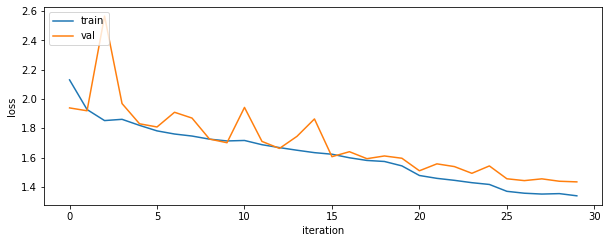

In [9]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

In [10]:
r = int(np.random.rand()*100)
print(y_train[r])
out = model.predict(x_train[:100])
print(out[r])

tf.Tensor([ 3.11196867 -5.54958664 -0.07489633], shape=(3,), dtype=float64)
[ 2.793902  -5.443067  -0.1253431]


In [11]:
test_file = "data/test_dxdy.npy"
test_dataset = np.load(test_file)
rand = int(np.shape(test_dataset)[0]*np.random.rand())

#test for standard case
# x_test = test_dataset[:,:100]
# x_test = tf.convert_to_tensor(x_test)

#test when looking at displacement between two measurements
x_temp2 = tf.convert_to_tensor(test_dataset[:,:100])
x_test = np.zeros([np.shape(test_dataset)[0], 50])
x_test[:,:50] = x_temp2[:,:50] - x_temp2[:,50:100]

y_test = test_dataset[:,100:]
y_test = tf.convert_to_tensor(y_test)
# print(y_test[rand])
print(y_train[rand])

# guess = model.predict(x_test)
guess = model.predict(x_train)
print(guess[rand])

tf.Tensor([-1.03825531 -1.18696428 -0.27855577], shape=(3,), dtype=float64)
[-0.66899127 -0.72045064 -0.2537779 ]


In [ ]:
# model.save("dead_reckoning_1pt22_mse.kmod") #got this with 50 input model

Results:

Best MSE with 100k dataset: 1.36

Best MSE with 300k dataset: 1.22

# Normal Distribution Transform (NDT)

Step 2: generate a normal distribution for each subset of points

In [12]:
from NDT import fit_gaussian

numpts = 10
points = np.random.randn(numpts, 2)

#adds order to points
# points[:,0] += np.linspace(1,10,numpts)
# points[:,1] += np.linspace(0,2,numpts)
 
mu, sigma = fit_gaussian(points)
print("mu = ", mu)
print("sigma = ", sigma)

eig = np.linalg.eig(sigma)
eigenval = eig[0]
eigenvec = eig[1]

print("eigenval = ", eigenval)
print("eigenvec = ", eigenvec)


mu =  [ 0.23899221 -0.62200275]
sigma =  [[ 1.07276725 -0.62068128]
 [-0.62068128  1.14169201]]
eigenval =  [0.48559235 1.72886691]
eigenvec =  [[-0.72644273  0.68722701]
 [-0.68722701 -0.72644273]]


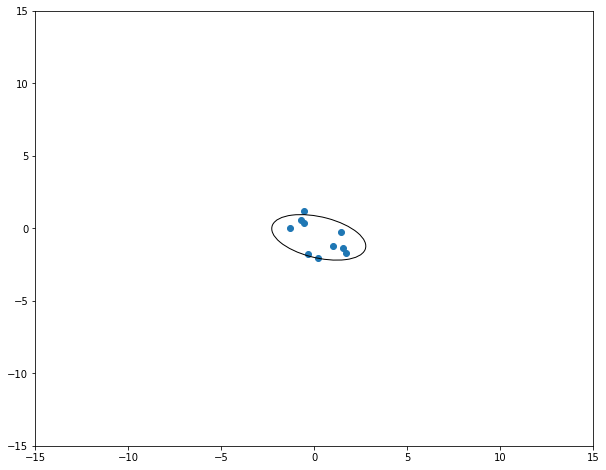

In [13]:
#draw ellipse around 1std to prove fit_guassian works
from matplotlib.patches import Ellipse

nstd = 2

fig2 = plt.figure(1)
ax2 = fig2.add_subplot()

patches = []

ax2.set_xlim(-15,15)
ax2.set_ylim(-15,15)
ax2.scatter(points[:,0], points[:,1])

rot = -np.rad2deg(np.arcsin(eigenvec[0,1]/eigenvec[0,0]))
width = 2*nstd*np.sqrt(eigenval[0])
height = 2*nstd*np.sqrt(eigenval[1])

ell = Ellipse((mu[0],mu[1]),width, height, angle = rot, fill = False)
ax2.add_patch(ell)


Step 1: Subdivide scan into grid cells:

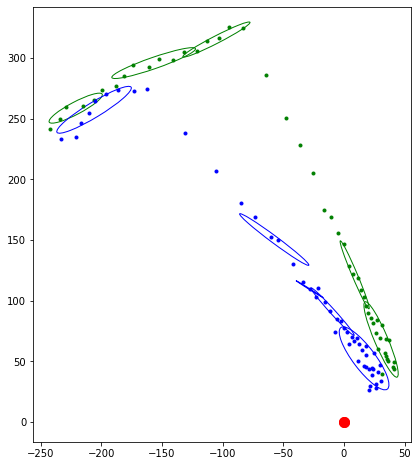

In [14]:
from NDT import draw_scan, subdivide_scan

fig3 = plt.figure(1)
ax3 = fig3.add_subplot()
ax3.set_aspect('equal')
rand2 = int(np.random.rand()*50) #82 is a simple corner, 2 is a doorway
# print(rand2)

# dat = dataset[:,:50] #regular data
dat = np.load("data/noisy_dxdy_100.npy")  #noisy data
dat1 = dat[:,:50]
dat2 = dat[:,50:100]

rand2 = 20

#get point positions and draw lidar scan
pp1 = draw_scan(dat1[rand2],fig3,ax3, pt = 0) 
pp2 = draw_scan(dat2[rand2],fig3,ax3, pt = 1) 

f = 6 #overall region of scan is broken down into a 5x5 scan
E1 = subdivide_scan(pp1,fig3,ax3, fidelity = f, pt =0)
E2 = subdivide_scan(pp2,fig3,ax3, fidelity = f, pt =1)

# green = before
# blue = after

In [ ]:
E1[0]